<a href="https://colab.research.google.com/github/nagusubra/ENDG511_Labs/blob/main/Lab3/ENDG511_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENDG 511 Lab 3 Assignment: Model Pruning and Quantization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to different model optimization methods using TensorFlow and Keras, and you will learn how to use them to create efficient deep learning models. The goals of this lab are:

- Understand the basics of pruning and quantization.
- Apply pruning and quantization to an MNIST model.
- Understand and use TFLite.
- Evaluate models in terms of accuracy, size and inference time.
- Understand how different pruning and quantization parameters can impact accuracy, size and inference time.
- Apply collaborative optimization by combining pruning and quantization.

## Layout
This lab is split into **three** parts. 
- **Part 1**: Apply pruning to an MNIST model and evaluate the pruned model.
- **Part 2**: Apply post-training quantization and evaluate the quantized model.
- **Part 3**: Combine pruning and post-training quantization and evaluate the final model.

## How to submit the Assignment 

- You are required to sumbmit the completed python notebook and a **pdf version** of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource. 
-  Lab sessions will be held to go over the main concepts and help you with the assignment.

- **Due Date: 17th February 2023**

# **Part 1**: Pruning

This part of the lab demonstrates applying pruning to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to prune and evaluate a model are as follows:

- Build and train the dense baseline
- Prune model
- Fine-tune pruned model
- Evaluate the model

There are different types of pruning techniques, the technique demonstrated in this lab is magnitude-based weight pruning (also referred to as unstructured pruning). Magnitude-based weight pruning gradually zeroes out model weights based on their importance during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements. The image below can help you visualize pruning:

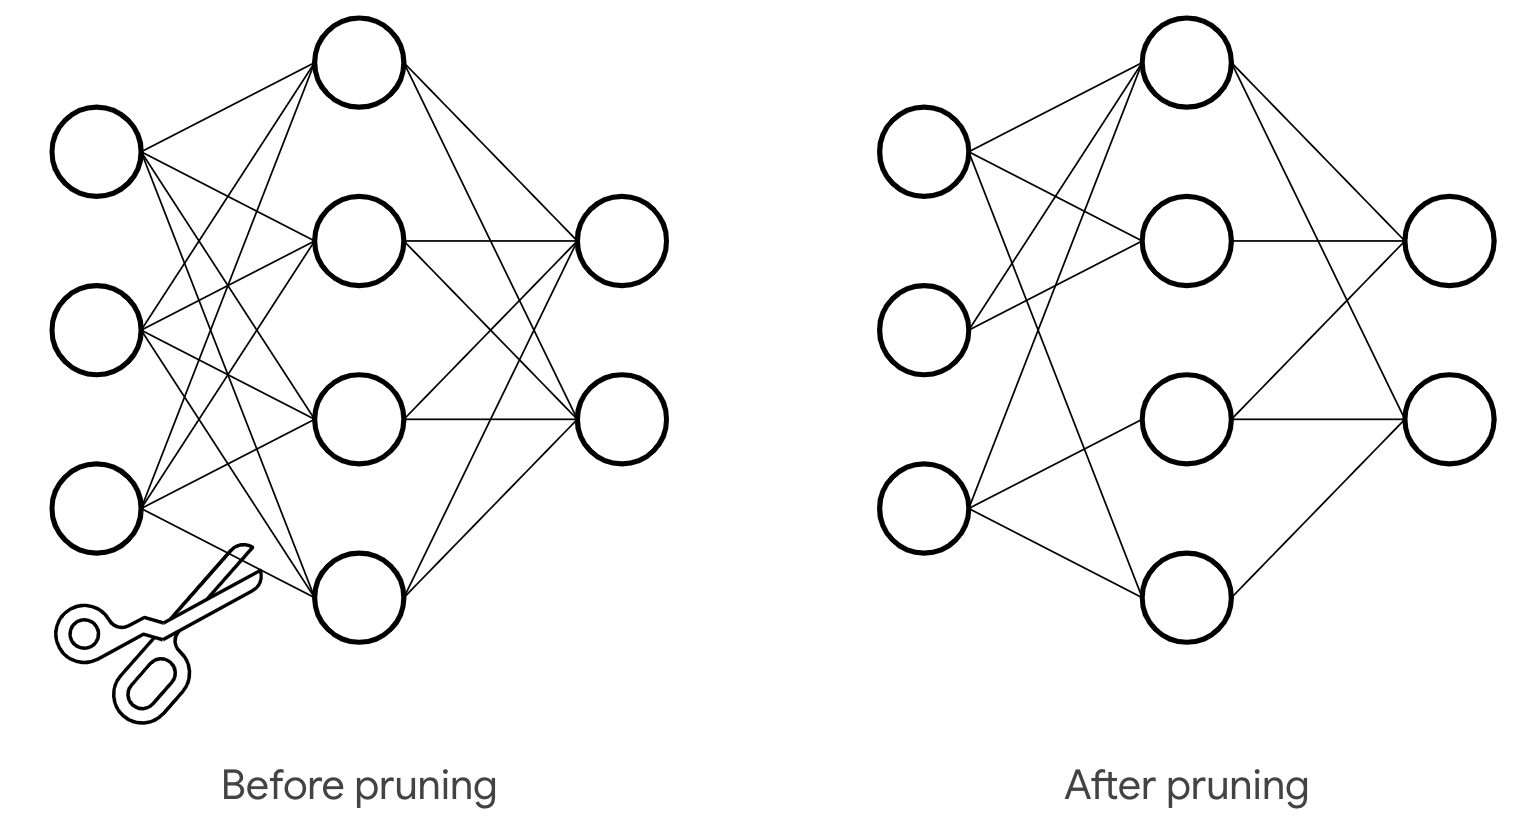

### Import and install all required modules

In [137]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot

### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training.


In [138]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

Epoch 1/5
1688/1688 [==============================] - 10s 5ms/step - loss: 0.3178 - accuracy: 0.9072 - val_loss: 0.1279 - val_accuracy: 0.9672
Epoch 2/5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.1532 - accuracy: 0.9549 - val_loss: 0.0917 - val_accuracy: 0.9743
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.1129 - accuracy: 0.9663 - val_loss: 0.0798 - val_accuracy: 0.9760
Epoch 4/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0909 - accuracy: 0.9720 - val_loss: 0.0761 - val_accuracy: 0.9788
Epoch 5/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0771 - accuracy: 0.9760 - val_loss: 0.0693 - val_accuracy: 0.9808


Let's display the architecture of our model:

In [139]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate at a later stage.

In [140]:
# Save your trained model
model.save('trained_base_model.h5')

### Prune the dense model
We will create a pruned model from our original model. We will force the model to have 50% sparsity (50% of the weights are zeroed out). Finally we recompile our new pruned model.

Note: ConstantSparsity performs "one-shot" magnitude based pruning of all the layers. There are more advanced techniques but this is the simplest one. The total number of parameters increases because tensorflow adds a "pruning wrapper" to all parameters, this gets stripped at a later stage.

In [141]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_2  (None, 128)              200834    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_3  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-tr

### Fine-tune pruned model
Next, we have to fine-tune our pruned model by retraining for a suitable number of epochs.
Note: tfmot.sparsity.keras.UpdatePruningStep is required as a callback during training.

In [142]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0712 - accuracy: 0.9774 - val_loss: 0.0654 - val_accuracy: 0.9813
Epoch 2/2
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 0.0646 - val_accuracy: 0.9822


### Apply strip pruning

strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to the final model size. It strips the pruning wrapper, It is also needed when converting to a TFLite model.

In [143]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [144]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense_2/kernel:0: 50.00% sparsity  (50176/100352)
dense_3/kernel:0: 50.00% sparsity  (640/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [145]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 1s 3ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374879.00 bytes
Base Inference Time is 0.00013802356719970702 s

Pruned Model Accuracy: 97.85000085830688 %
Pruned Model Size: 234719.00 bytes
Pruned Inference Time is 0.0001152719497680664 s


### Excercies: (1.5 points)


#### Question 1: 

Load the trained base model (unpruned). Prune the model with a target sparsity of 90%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [146]:
# INSERT YOUR CODE HERE

##### Load the model


In [147]:
# Loading the base model (unpruned)
model_part_1_q1 = keras.models.load_model('trained_base_model.h5')

##### Prune the model


In [148]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.9 is the target sparsity (90%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.9, begin_step=0, frequency=100)
}

pruned_model_part_1_q1 = prune_low_magnitude(model_part_1_q1, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_part_1_q1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_part_1_q1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_2  (None, 128)              200834    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_3  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-tr

##### Fine tune


In [149]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_part_1_q1.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.5069 - accuracy: 0.8499 - val_loss: 0.1984 - val_accuracy: 0.9485
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3066 - accuracy: 0.9079 - val_loss: 0.1556 - val_accuracy: 0.9567


##### Apply strip pruning

In [150]:
stripped_pruned_model_part_1_q1 = tfmot.sparsity.keras.strip_pruning(pruned_model_part_1_q1)
stripped_pruned_model_part_1_q1.save('stripped_pruned_model_part_1_q1.h5')

##### Evaluate the model

In [151]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_90, test_acc_pruned_90 = pruned_model_part_1_q1.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_part_1_q1.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_09_model_size = get_gzipped_model_size('stripped_pruned_model_part_1_q1.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_09_model_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374879.00 bytes
Base Inference Time is 7.36168384552002e-05 s

Pruned Model Accuracy: 95.09000182151794 %
Pruned Model Size: 79847.00 bytes
Pruned Inference Time is 0.00013976860046386718 s


Evaluating the model in terms of accuracy, model size and inference time:

| New Model | Base Model |
|------------|------------|
| - Overall accuracy: Lower by 2-3%| - Overall accuracy: Higher|
| - Overall Inference time: Much lower | - Overall Inference time: Much higher|
| - Performance: Higher| - Performance: Lower|
| - Key: Reduced accuracy with lower model size and inference time| - Key: Higher accuracy at the cost of bigger size and larger inference time|


1. Accuracy: We are trading off accuracy to get a much smaller size with 90% prunned model.
2. Model size: We have reduced model size dramaticaly from 374879.00 bytes to 79847.00 bytes.
3. Inference time: We have reduced inference time dramaticaly from 7.36168384552002e-05 s to 0.00013976860046386718 s.


Evidence that Deep NNs can be compressed effectively, and:
• Are usually very sparse
• Have redundancy
• Large degrees of freedom allow weights to be quantized

#### Question 2: 

Load the trained base model (unpruned). Prune the model with a target sparsity of 10%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [152]:
# INSERT YOUR CODE HERE

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0535 - accuracy: 0.9831 - val_loss: 0.0647 - val_accuracy: 0.9818
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0480 - accuracy: 0.9851 - val_loss: 0.0670 - val_accuracy: 0.9825


##### Load the model


In [153]:
# Loading the base model (unpruned)
model_part_1_q2 = keras.models.load_model('trained_base_model.h5')

##### Prune the model

In [154]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.1 is the target sparsity (10%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
}

pruned_model_part_1_q2 = prune_low_magnitude(model_part_1_q2, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_part_1_q2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_part_1_q2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_2  (None, 128)              200834    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_3  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-tr

##### Fine tune

In [155]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_part_1_q2.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 12s 6ms/step - loss: 0.0669 - accuracy: 0.9784 - val_loss: 0.0655 - val_accuracy: 0.9808
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.0693 - val_accuracy: 0.9812


##### Apply strip pruning

In [156]:
stripped_pruned_model_part_1_q2 = tfmot.sparsity.keras.strip_pruning(pruned_model_part_1_q2)
stripped_pruned_model_part_1_q2.save('stripped_pruned_model_part_1_q2.h5')

##### Evaluate the model

In [157]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_10, test_acc_pruned_10 = pruned_model_part_1_q2.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_part_1_q2.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_01_model_size = get_gzipped_model_size('stripped_pruned_model_part_1_q2.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_01_model_size))
print("Pruned Inference Time is", executionTimePruned10, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374879.00 bytes
Base Inference Time is 7.359192371368408e-05 s

Pruned Model Accuracy: 97.79000282287598 %
Pruned Model Size: 358945.00 bytes
Pruned Inference Time is 7.771666049957276e-05 s


Evaluating the model in terms of accuracy, model size and inference time:

| New Model | Base Model |
|------------|------------|
| - Overall accuracy: Almost the same (it should be a lower with a small delta)| - Overall accuracy: Almost the same|
| - Overall Inference time: It should have been lower, but here it is more than the base model even after 10P | - Overall Inference time: Higher (for this case)|
| - Performance: Higher| - Performance: Lower|
| - Key: Maintained accuracy with lower model size and inference time| - Key: Higher accuracy at the cost of bigger size and larger inference time|


1. Accuracy: We are trading off accuracy to get a smaller size with 10% prunned model.
2. Model size: We have reduced model size from 374879.00 bytes to 358945.00 bytes.
3. Inference time: We should have reduced inference time, but in this specific code we have not got a lower inference time.


Evidence that Deep NNs can be compressed effectively, and:
• Are usually very sparse
• Have redundancy
• Large degrees of freedom allow weights to be quantized

####Question 3: 

Plot a bar graph to show how each metric varies at a different sparsity %ages of 0%, 10%, 30%, 50%, 70%, and 90% (3 graphs in total). **(0.5 points)**

##### 30% and 70% Sparsity
Loading, Pruning, Fine Tuning, Stripping and Evaluating the model for 

In [158]:
# Loading the base model (unpruned)
model_part_1_q3 = keras.models.load_model('trained_base_model.h5')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after




# Define model for pruning. The 0.3 is the target sparsity (30%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.3, begin_step=0, frequency=100)
}

pruned_model_part_1_q3_03 = prune_low_magnitude(model_part_1_q3, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_part_1_q3_03.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




# Define model for pruning. The 0.7 is the target sparsity (70%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.7, begin_step=0, frequency=100)
}

pruned_model_part_1_q3_07 = prune_low_magnitude(model_part_1_q3, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_part_1_q3_07.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



# pruned_model_part_1_q3_03.summary()
# pruned_model_part_1_q3_07.summary()







callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_part_1_q3_03.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

pruned_model_part_1_q3_07.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)









stripped_pruned_model_part_1_q3_03 = tfmot.sparsity.keras.strip_pruning(pruned_model_part_1_q3_03)
stripped_pruned_model_part_1_q3_03.save('stripped_pruned_model_part_1_q3_03.h5')

stripped_pruned_model_part_1_q3_07 = tfmot.sparsity.keras.strip_pruning(pruned_model_part_1_q3_07)
stripped_pruned_model_part_1_q3_07.save('stripped_pruned_model_part_1_q3_07.h5')




# Evaluate prediction accuracy
test_loss_pruned_30, test_acc_pruned_30 = pruned_model_part_1_q3_03.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_model_part_1_q3_03.predict(test_images)
executionTimePruned30 = (time.time() - startTime)/len(test_images)

# Evaluate Model Size
pruned_03_model_size = get_gzipped_model_size('stripped_pruned_model_part_1_q3_03.h5')





# Evaluate prediction accuracy
test_loss_pruned_70, test_acc_pruned_70 = pruned_model_part_1_q3_07.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_model_part_1_q3_07.predict(test_images)
executionTimePruned70 = (time.time() - startTime)/len(test_images)

# Evaluate Model Size
pruned_07_model_size = get_gzipped_model_size('stripped_pruned_model_part_1_q3_07.h5')






Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0648 - accuracy: 0.9793 - val_loss: 0.0684 - val_accuracy: 0.9805
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0566 - accuracy: 0.9815 - val_loss: 0.0704 - val_accuracy: 0.9800
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0942 - accuracy: 0.9706 - val_loss: 0.0681 - val_accuracy: 0.9807
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0692 - accuracy: 0.9781 - val_loss: 0.0668 - val_accuracy: 0.9818


313/313 [==============================] - 1s 2ms/step


In [159]:
accuracy_list = [test_acc, test_acc_pruned_10, test_acc_pruned_30,test_acc_pruned_50, test_acc_pruned_70, test_acc_pruned_90]
# print(accuracy_list)

inference_time_list = [executionTime, executionTimePruned10, executionTimePruned30, executionTimePruned50, executionTimePruned70, executionTimePruned90]
# print(inference_time_list)

size_list = [base_model_size, pruned_01_model_size,pruned_03_model_size, pruned_model_size, pruned_07_model_size, pruned_09_model_size]
# print(size_list)

x_axis = [0,10,30,50,70,90]

In [160]:
#1 Accuracy of transfered learning
plt.rcParams["figure.figsize"] = (6,5)

def plot_metrics_list(metrics_list, x_axis, y_label, Graph_text):

  y = np.array(metrics_list)
  x = np.array(x_axis)

  plt.title(Graph_text)
  plt.plot(x, y, color="red")
  plt.legend(loc="upper left")
  plt.ylabel(y_label)
  plt.xlabel('% Sparsity')
  plt.show()

  # return test_acc_list

##### Accuracy comparison

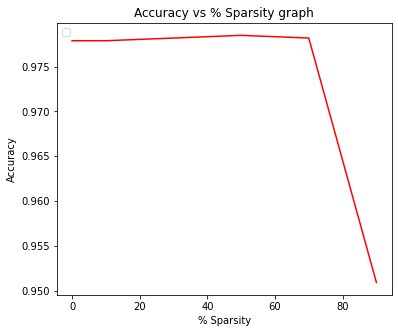

In [161]:
# INSERT YOUR CODE HERE
# Graph for Model Accuracy
plot_metrics_list(accuracy_list, x_axis, "Accuracy", "Accuracy vs % Sparsity graph")

We see a sharp decrease in accuracy after 70% of the model pruned, but the accuracy difference does not go below 95% which is good.

##### Inference time comparison

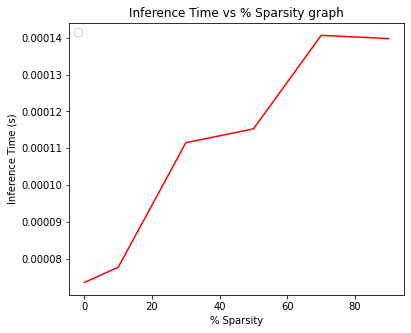

In [221]:
# INSERT YOUR CODE HERE
# Graph for Inference Time
plot_metrics_list(inference_time_list, x_axis, "Inference Time (s)", "Inference Time vs % Sparsity graph")

We see a increase in Inference time  with more layers model pruned. 

Actually in reality we should see a decrease in infrence time as the pruned layers increase, but in this case it does not seem so. The reason is because with more pruned layers we have lesser neurons connected and lesser math operations to do, as well as the footprint of the mdoel is small. So the model preductions should be quicker.

##### Model Size comparison

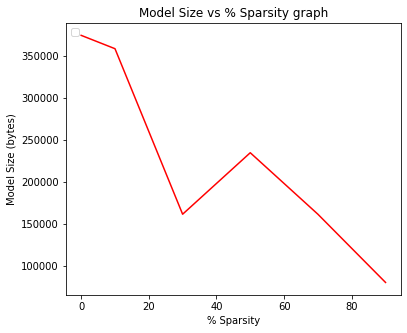

In [223]:
# INSERT YOUR CODE HERE
# Graph for Model Size
plot_metrics_list(size_list, x_axis, "Model Size (bytes)", "Model Size vs % Sparsity graph")

The model size decrease with increasing pruned layers as expected.

# **Part 2**:  Quantization
This part of the lab demonstrates applying quantization to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Apply quantization during conversion to TFLite
- Evaluate the model

There are different quantization techniques, the technique demonstrated in this lab is post-training quantization. The main idea behind quantization is that the weights and activations can be converted to types with reduced precision, such as 16 bit floats or 8 bit integers instead of 32 bit floats which can signficantly reduce model size and inference with minimal accuracy tradeoffs.

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

A TensorFlow Lite model is represented in a special efficient portable format known as FlatBuffers (identified by the .tflite file extension). This provides several advantages over TensorFlow's protocol buffer model format such as reduced size (small code footprint) and faster inference (data is directly accessed without an extra parsing/unpacking step) that enables TensorFlow Lite to execute efficiently on devices with limited compute and memory resources.
You can find more information here: https://www.tensorflow.org/lite/guide

### Load base model
Firstly, let us load the base model we have trained earlier.

In [164]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Convert to TFLite and apply quantization
The next step is converting the base model to a TFLite model and applying quantization through the different APIs that TFLite provides. In this example we are using 8-bit quantization, this is done by using the DEFAULT optimizer. The commented codes provide an example of how to apply 16-bit floating point quantization.

In [165]:
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT] # 8 bit quantization
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

### Save TFLite model and load model into an interpeter
Firstly we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. 
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [166]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantized model in terms of accuracy, inference time and model size.

In [167]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')


Model Accuracy: 97.78 %
Model Size: 82887.00 bytes
Inference Time is:  1.0728836059570312e-09 s


(0.9778, 82887, 1.0728836059570312e-09)

In [168]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Exercise (0.5 points)

Question 1: Load the base model and apply 16 bit floating point quantization. Use the TFLite interpeter to evaluate your model. **(0.5 points)**

In [169]:
# INSERT YOUR CODE HERE
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_model = converter.convert()

with open('fp16_quantized_tflite_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_model)
interpreter_fp16_quant = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_model.tflite'))
interpreter_fp16_quant.allocate_tensors()

evaluate_model(interpreter_fp16_quant, 'fp16_quantized_tflite_model.tflite')


Model Accuracy: 97.78999999999999 %
Model Size: 189995.00 bytes
Inference Time is:  1.049041748046875e-09 s


(0.9779, 189995, 1.049041748046875e-09)

In [170]:
def get_quantized_model(model_to_quantize, quantization_str, file_index_str):
  # INSERT YOUR CODE HERE

  # if quantization_str == "fp16":
  #   quantization_variable = tf.float16
  # elif "8-bit":
  #   quantization_variable = np.int8
  # else:
  #   quantization_variable = tf.float32

  converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # default of 8 bit quantization

  if quantization_str == "fp16":
    converter.target_spec.supported_types = [tf.float16] # 16 bit quantization
  # elif quantization_str == "8-bit":
  #   pass
  # else:
  #   pass
  
  fp_quantized_tflite_model = converter.convert()


  model_file_str = 'quantized_tflite_model_' + str(quantization_str) + '_' +str(file_index_str) + '_' + '.tflite'
  print("model_file_str: ", model_file_str)

  with open(model_file_str, 'wb') as f:
    f.write(fp_quantized_tflite_model)
  interpreter_quant = tf.lite.Interpreter(model_path=str(model_file_str))
  interpreter_quant.allocate_tensors()

  return interpreter_quant, model_file_str

In [171]:
eight_bit_quantized_model, model_file_str = get_quantized_model(tf.keras.models.load_model('trained_base_model.h5'), "8-bit", "01111") #testing 8-bit
Accuracy, Size, Inference_time = evaluate_model(eight_bit_quantized_model, model_file_str)

model_file_str:  quantized_tflite_model_8-bit_01111_.tflite

Model Accuracy: 97.78 %
Model Size: 82913.00 bytes
Inference Time is:  1.0013580322265624e-09 s


In [172]:
# INSERT YOUR CODE HERE
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter_8 = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter_8.optimizations = [tf.lite.Optimize.DEFAULT]
# converter_8.target_spec.supported_types = [np.int8] # 8 bit quantization
fp8_quantized_tflite_model = converter_8.convert()

with open('fp8_quantized_tflite_model_1.tflite', 'wb') as f:
  f.write(fp8_quantized_tflite_model)
interpreter_fp8_quant = tf.lite.Interpreter(model_path=str('fp8_quantized_tflite_model_1.tflite'))
interpreter_fp8_quant.allocate_tensors()

evaluate_model(interpreter_fp8_quant, 'fp8_quantized_tflite_model_1.tflite')


Model Accuracy: 97.78 %
Model Size: 82899.00 bytes
Inference Time is:  1.0251998901367188e-09 s


(0.9778, 82899, 1.0251998901367188e-09)

# Part 3: Collaborative Optimization



### Exercise



#### Question 1

(2 points): Using the knowledge from part 1 and part 2, jointly apply pruning and post-training quantization to the base MNIST model. 

Try the following combinations and plot 3 graphs (one for each metric of accuracy, model size , and inference time):

- no pruning, no quantization
- no pruning, fp16 quantization
- no pruning, 8-bit quantization

- 10% sparsity, no quantization
- 10% sparsity, fp16 quantization
- 10% sparsity, 8-bit quantization

- 50% sparsity, no quantization
- 50% sparsity, fp16 quantization
- 50% sparsity, 8-bit quantization

- 90% sparsity, no quantization
- 90% sparsity, fp16 quantization
- 90% sparsity, 8-bit quantization

To do this, write a prune_and_quantize function and loop over different sparsities and then append all the results into 3 different arrays (one for each metric).

For example the function definition could look like this:

**def prune_and_quantize(model, target_sparsity, fp16: bool, path_to_save)**

Hint: Below is an example of how you can graph your results using matplotlib
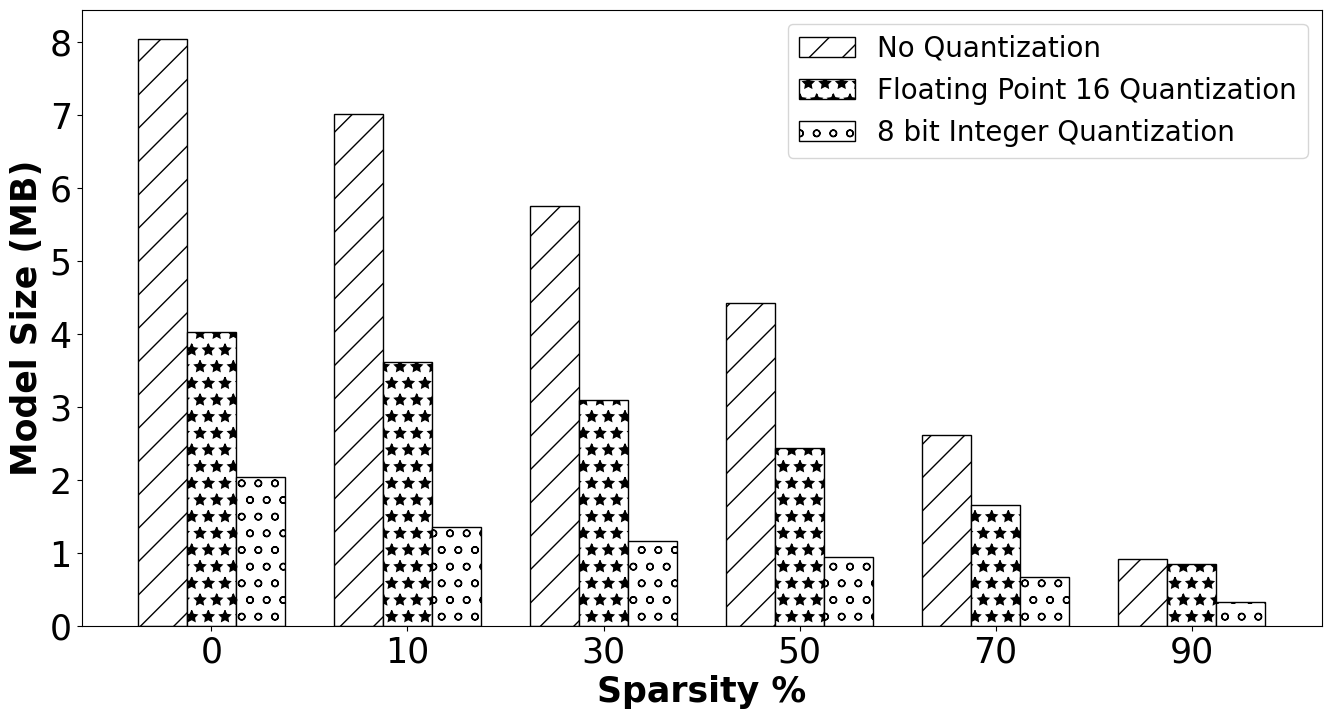

In [173]:
def prune_model(model, target_sparsity, quantization_str, path_to_save, index_string):
  
  print("The save path in prune_model: ", path_to_save)

  if target_sparsity > 0:
    # Define model for pruning. The target_sparsity is the target sparsity (target_sparsity%)
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)
    }

    pruned_model = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # pruned_model.summary()

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                      callbacks=callbacks)
    

    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
    stripped_pruned_model.save(path_to_save)

  else: # no pruning
    pruned_model = model
    stripped_pruned_model = model
    stripped_pruned_model.save(path_to_save)
  
  return pruned_model, path_to_save

In [174]:
def prune_and_quantize(model, target_sparsity, quantization_str, path_to_save, index_string):

  pruned_model, path_to_save = prune_model(model, target_sparsity, quantization_str, path_to_save, index_string)
  
  # quantization

  if quantization_str == "":

    # Evaluate prediction accuracy
    test_loss_pruned, test_acc_pruned = pruned_model.evaluate(test_images,  test_labels, verbose=0)

    # Evaluate Inference Time
    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTimePruned = (time.time() - startTime)/len(test_images)

    # Evaluate Model Size (for the stripped model)
    pruned_model_size = get_gzipped_model_size(path_to_save)

    # return pruned_and_quantized_model, test_acc_pruned, executionTimePruned, pruned_model_size
    return pruned_model, test_acc_pruned, executionTimePruned, pruned_model_size

  else:
    quantized_model, model_file_str = get_quantized_model(pruned_model, quantization_str, index_string)
    pruned_and_quantized_model = quantized_model
    # evaluate_model(pruned_and_quantized_model, model_file_str)
    pruned_and_quantized_model_Accuracy, pruned_and_quantized_model_Size, pruned_and_quantized_model_Inference_time = evaluate_model(pruned_and_quantized_model, model_file_str)

    return pruned_and_quantized_model, pruned_and_quantized_model_Accuracy, pruned_and_quantized_model_Inference_time, pruned_and_quantized_model_Size
  

In [175]:
# pruned_and_quantized_model, test_acc_pruned, executionTimePruned, pruned_model_size = prune_and_quantize(keras.models.load_model('trained_base_model.h5'), 0.5, "", 'stripped_pruned_model_part_1_q3_test.h5')
# print(test_acc_pruned, "   ", executionTimePruned, "   ", pruned_model_size)

In [176]:
# pruned_and_quantized_model, test_acc_pruned, executionTimePruned, pruned_model_size = prune_and_quantize(keras.models.load_model('trained_base_model.h5'), 0.9, "", 'stripped_pruned_model_part_1_q3_test.h5')
# print(test_acc_pruned, "   ", executionTimePruned, "   ", pruned_model_size)

In [177]:
# pruned_and_quantized_model, test_acc_pruned, executionTimePruned, pruned_model_size = prune_and_quantize(keras.models.load_model('trained_base_model.h5'), 0.1, "", 'stripped_pruned_model_part_1_q3_test.h5')
# print(test_acc_pruned, "   ", executionTimePruned, "   ", pruned_model_size)

In [178]:
import pandas as pd

pruning_values = [0, 10, 50, 90]
quantization_strings = ["","8-bit", "fp16"]
index_count = 0

graphing_df = pd.DataFrame()

base_model = keras.models.load_model('trained_base_model.h5')

for quantization_string in quantization_strings:
  for pruning_value in pruning_values:

    pruning_value_copy = pruning_value
    pruning_value = pruning_value/100.0

    path_to_save_str = 'stripped_pruned_model_part_3_'+ quantization_string + '_' + str(index_count) + '_' +'.h5'

    print("\n\nThe current pruning: ", pruning_value, " and the quantization: ", quantization_string)
    pruned_and_quantized_model, test_acc_pruned_and_quantized, executionTimePruned_and_quantized, pruned_and_quantized_model_size = prune_and_quantize(base_model, pruning_value, quantization_string, path_to_save_str, str(index_count)+'___')
    
    print("\n\n")
    try:
      print_model_weights_sparsity(pruned_and_quantized_model)
    except:
      pass

    quantization_string_dict = {
                                    "": "No quantization",
                                    "fp16": "Floating 16 quantization",
                                    "8-bit": "8 bit integer quantization"
                                }

    df_dict = {
                'Accuracy' : test_acc_pruned_and_quantized,
                'Inference_Time' : executionTimePruned_and_quantized,
                'Model_Size' : pruned_and_quantized_model_size,
                'Quantization': quantization_string_dict[quantization_string],
                'Sparsity': pruning_value_copy
              }
    df = pd.DataFrame(df_dict, index=[index_count])
    graphing_df = pd.concat([graphing_df, df])
    print(df)
    index_count+=1
    print("\n\n")



The current pruning:  0.0  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__0_.h5
313/313 [==============================] - 1s 2ms/step



dense_2/kernel:0: 0.00% sparsity  (0/100352)
dense_3/kernel:0: 0.00% sparsity  (0/1280)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
0    0.9779        0.000069     1058194  No quantization         0





The current pruning:  0.1  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__1_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0669 - accuracy: 0.9792 - val_loss: 0.0697 - val_accuracy: 0.9807
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0575 - accuracy: 0.9812 - val_loss: 0.0650 - val_accuracy: 0.9818


313/313 [==============================] - 1s 2ms/step



dense_2/kernel:0: 10.00% sparsity  (10035/100352)
dense_3/kernel:0: 10.00% sparsity  (128/1280)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
1    0.9813        0.000074      358881  No quantization        10





The current pruning:  0.5  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__2_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.0666 - val_accuracy: 0.9818
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0661 - val_accuracy: 0.9818


313/313 [==============================] - 1s 2ms/step



dense_2/kernel:0: 50.00% sparsity  (50176/100352)
dense_3/kernel:0: 50.00% sparsity  (640/1280)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
2    0.9812        0.000074      234347  No quantization        50





The current pruning:  0.9  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__3_.h5
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.5253 - accuracy: 0.8319 - val_loss: 0.2215 - val_accuracy: 0.9362
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3354 - accuracy: 0.8926 - val_loss: 0.1791 - val_accuracy: 0.9527


313/313 [==============================] - 1s 2ms/step



dense_2/kernel:0: 90.00% sparsity  (90317/100352)
dense_3/kernel:0: 90.00% sparsity  (1152/1280)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
3    0.9466        0.000076       79597  No quantization        90





The current pruning:  0.0  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_4_.h5


model_file_str:  quantized_tflite_model_8-bit_4____.tflite

Model Accuracy: 94.67999999999999 %
Model Size: 20785.00 bytes
Inference Time is:  1.049041748046875e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
4    0.9468    1.049042e-09       20785  8 bit integer quantization         0





The current pruning:  0.1  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_5_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.1593 - accuracy: 0.9517 - val_loss: 0.0778 - val_accuracy: 0.9780
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0928 - accuracy: 0.9709 - val_loss: 0.0818 - val_accuracy: 0.9768


model_file_str:  quantized_tflite_model_8-bit_5____.tflite

Model Accuracy: 97.5 %
Model Size: 346437.00 bytes
Inference Time is:  9.60826873779297e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
5     0.975    9.608269e-09      346437  8 bit integer quantization        10





The current pruning:  0.5  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_6_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0713 - accuracy: 0.9782 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0583 - accuracy: 0.9810 - val_loss: 0.0645 - val_accuracy: 0.9838


model_file_str:  quantized_tflite_model_8-bit_6____.tflite

Model Accuracy: 98.11999999999999 %
Model Size: 259704.00 bytes
Inference Time is:  1.895427703857422e-08 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
6    0.9812    1.895428e-08      259704  8 bit integer quantization        50





The current pruning:  0.9  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_7_.h5
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2660 - accuracy: 0.9140 - val_loss: 0.1565 - val_accuracy: 0.9580
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2518 - accuracy: 0.9188 - val_loss: 0.1466 - val_accuracy: 0.9617


model_file_str:  quantized_tflite_model_8-bit_7____.tflite

Model Accuracy: 95.38 %
Model Size: 92313.00 bytes
Inference Time is:  1.9860267639160156e-08 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
7    0.9538    1.986027e-08       92313  8 bit integer quantization        90





The current pruning:  0.0  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_8_.h5


model_file_str:  quantized_tflite_model_fp16_8____.tflite

Model Accuracy: 95.38 %
Model Size: 45489.00 bytes
Inference Time is:  1.0967254638671875e-09 s



   Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
8    0.9538    1.096725e-09       45489  Floating 16 quantization         0





The current pruning:  0.1  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_9_.h5
Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.1408 - accuracy: 0.9559 - val_loss: 0.0782 - val_accuracy: 0.9793
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0860 - accuracy: 0.9728 - val_loss: 0.0747 - val_accuracy: 0.9807


model_file_str:  quantized_tflite_model_fp16_9____.tflite

Model Accuracy: 97.43 %
Model Size: 178197.00 bytes
Inference Time is:  1.0228157043457031e-08 s



   Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
9    0.9743    1.022816e-08      178197  Floating 16 quantization        10





The current pruning:  0.5  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_10_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0649 - accuracy: 0.9792 - val_loss: 0.0647 - val_accuracy: 0.9832
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0537 - accuracy: 0.9825 - val_loss: 0.0661 - val_accuracy: 0.9840


model_file_str:  quantized_tflite_model_fp16_10____.tflite

Model Accuracy: 98.04 %
Model Size: 153401.00 bytes
Inference Time is:  1.5878677368164064e-08 s



    Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
10    0.9804    1.587868e-08      153401  Floating 16 quantization        50





The current pruning:  0.9  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_11_.h5
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.2281 - accuracy: 0.9260 - val_loss: 0.1417 - val_accuracy: 0.9618
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2207 - accuracy: 0.9275 - val_loss: 0.1357 - val_accuracy: 0.9613


model_file_str:  quantized_tflite_model_fp16_11____.tflite

Model Accuracy: 95.73 %
Model Size: 63488.00 bytes
Inference Time is:  2.148151397705078e-08 s



    Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
11    0.9573    2.148151e-08       63488  Floating 16 quantization        90





In [179]:
graphing_df

,Accuracy,Inference_Time,Model_Size,Quantization,Sparsity
0,0.9779,6.901360e-05,1058194,No quantization,0
1,0.9813,7.447667e-05,358881,No quantization,10
2,0.9812,7.363896e-05,234347,No quantization,50
3,0.9466,7.623000e-05,79597,No quantization,90
4,0.9468,1.049042e-09,20785,8 bit integer quantization,0
5,0.9750,9.608269e-09,346437,8 bit integer quantization,10
6,0.9812,1.895428e-08,259704,8 bit integer quantization,50
7,0.9538,1.986027e-08,92313,8 bit integer quantization,90
8,0.9538,1.096725e-09,45489,Floating 16 quantization,0
9,0.9743,1.022816e-08,178197,Floating 16 quantization,10


In [180]:
display(graphing_df[["Sparsity","Quantization","Model_Size"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Model_Size').reset_index())

Quantization,Sparsity,8 bit integer quantization,Floating 16 quantization,No quantization
0,0,20785,45489,1058194
1,10,346437,178197,358881
2,50,259704,153401,234347
3,90,92313,63488,79597


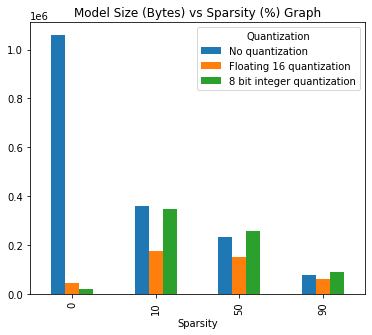

In [224]:
import matplotlib.pyplot as plt

# plot grouped bar chart
graph_df_Model_size = graphing_df[["Sparsity","Quantization","Model_Size"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Model_Size').reset_index().copy()
graph_df_Model_size = graph_df_Model_size[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_Model_size.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Model Size (Bytes) vs Sparsity (%) Graph'
                      )

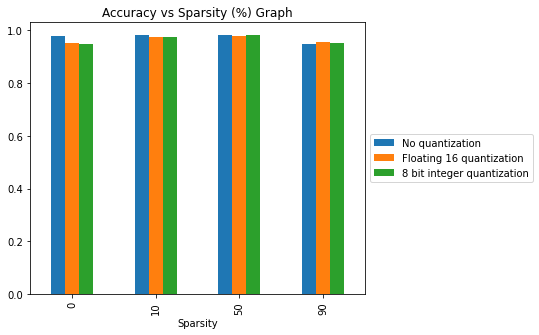

In [225]:
graph_df_Accuracy = graphing_df[["Sparsity","Quantization","Accuracy"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Accuracy').reset_index().copy()
graph_df_Accuracy = graph_df_Accuracy[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_Accuracy.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Accuracy vs Sparsity (%) Graph'
                      ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Plotting two graphs for the inference time since the scaling is not the same for No quatization vs fp16 and 8-bit quantization. This will help us to see the trends better.

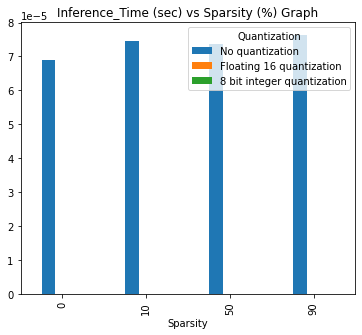

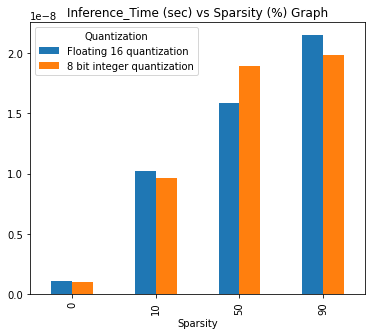

In [227]:
graph_df_inference_time = graphing_df[["Sparsity","Quantization","Inference_Time"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Inference_Time').reset_index().copy()
graph_df_inference_time = graph_df_inference_time[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_inference_time.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Inference_Time (sec) vs Sparsity (%) Graph'
                      )

graph_df_inference_time = graph_df_inference_time[["Sparsity", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_inference_time.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Inference_Time (sec) vs Sparsity (%) Graph'
                      )

#### Question-2 
(1 point) **Redo question 1** above (using the funnction that you wrote) but this time using the CNN model that you proposed in Lab-1 Q4 as the base model. **Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization.** 

This time, also plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. **Does the histogram of pruned weights give any insights on the accuracy observed?**

In [184]:
mnist = tf.keras.datasets.mnist
(train_images1, train_labels1), (test_images1, test_labels1) = mnist.load_data()
#train_images1 = np.expand_dims(train_images1, -1)
#test_images1 = np.expand_dims(test_images1, -1)
# Normalize pixel values to be between 0 and 1
train_images1, test_images1 = train_images1 / 255.0, test_images1 / 255.0
train_images1=np.expand_dims(train_images1, axis=-1)
test_images1= np.expand_dims(test_images1, axis=-1)
test_images1[1].shape

(28, 28, 1)

In [185]:
base_model_lab_1 = keras.models.load_model('part2_model_q4.h5') 

In [186]:
# Passing the Keras model to the TFLite Converter.
converter_lab1 = tf.lite.TFLiteConverter.from_keras_model(base_model_lab_1)
# Setting the deault optimizer
converter_lab1.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model_lab1 = converter_lab1.convert()

In [187]:
# Save TFLite Model
with open('quantized_tflite_model_lab1.tflite', 'wb') as f:
  f.write(quantized_tflite_model_lab1)
# Load model into interpeter
interpreter_quant_lab1 = tf.lite.Interpreter(model_path=str('quantized_tflite_model_lab1.tflite'))
interpreter_quant_lab1.allocate_tensors()

In [188]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model_special(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images1:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    try:
      interpreter.set_tensor(input_index, test_image)
    except:
      test_image = np.expand_dims(test_image, axis=0)
      interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images1)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels1[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model_lab1.tflite')


Model Accuracy: 97.78 %
Model Size: 8083.00 bytes
Inference Time is:  1.6927719116210938e-09 s


(0.9778, 8083, 1.6927719116210938e-09)

In [189]:
def prune_and_quantize_special(model, target_sparsity, quantization_str, path_to_save, index_string):

  pruned_model, path_to_save = prune_model(model, target_sparsity, quantization_str, path_to_save, index_string)
  
  # quantization

  if quantization_str == "":

    # Evaluate prediction accuracy
    test_loss_pruned, test_acc_pruned = pruned_model.evaluate(test_images,  test_labels, verbose=0)

    # Evaluate Inference Time
    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTimePruned = (time.time() - startTime)/len(test_images)

    # Evaluate Model Size (for the stripped model)
    pruned_model_size = get_gzipped_model_size(path_to_save)

    # return pruned_and_quantized_model, test_acc_pruned, executionTimePruned, pruned_model_size
    return pruned_model, test_acc_pruned, executionTimePruned, pruned_model_size

  else:
    quantized_model, model_file_str = get_quantized_model(pruned_model, quantization_str, index_string)
    pruned_and_quantized_model = quantized_model
    # evaluate_model(pruned_and_quantized_model, model_file_str)
    pruned_and_quantized_model_Accuracy, pruned_and_quantized_model_Size, pruned_and_quantized_model_Inference_time = evaluate_model_special(pruned_and_quantized_model, model_file_str)

    return pruned_and_quantized_model, pruned_and_quantized_model_Accuracy, pruned_and_quantized_model_Inference_time, pruned_and_quantized_model_Size
  

In [190]:
# INSERT YOUR CODE HERE
import pandas as pd

pruning_values = [0, 10, 50, 90]
quantization_strings = ["","8-bit", "fp16"]
index_count = 0

graphing_df_part_2 = pd.DataFrame()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

base_model = keras.models.load_model('part2_model_q4.h5')

base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


for quantization_string in quantization_strings:
  for pruning_value in pruning_values:

    pruning_value_copy = pruning_value
    pruning_value = pruning_value/100.0

    path_to_save_str = 'stripped_pruned_model_part_3_'+ quantization_string + '_' + str(index_count) + '_' +'.h5'

    print("\n\nThe current pruning: ", pruning_value, " and the quantization: ", quantization_string)
    pruned_and_quantized_model, test_acc_pruned_and_quantized, executionTimePruned_and_quantized, pruned_and_quantized_model_size = prune_and_quantize_special(base_model, pruning_value, quantization_string, path_to_save_str, str(index_count)+'___lab1')
    print("\n\n")
    try:
      pruned_and_quantized_model.save('pruned_and_quantized_model_part3_q2'+'_'+str(index_count)+'_'+'.h5')
      print_model_weights_sparsity(pruned_and_quantized_model)
    except:
      pass

    quantization_string_dict = {
                                    "": "No quantization",
                                    "fp16": "Floating 16 quantization",
                                    "8-bit": "8 bit integer quantization"
                                }

    df_dict = {
                'Accuracy' : test_acc_pruned_and_quantized,
                'Inference_Time' : executionTimePruned_and_quantized,
                'Model_Size' : pruned_and_quantized_model_size,
                'Quantization': quantization_string_dict[quantization_string],
                'Sparsity': pruning_value_copy
              }
    df = pd.DataFrame(df_dict, index=[index_count])
    graphing_df_part_2 = pd.concat([graphing_df_part_2, df])
    print(df)
    index_count+=1
    print("\n\n")



The current pruning:  0.0  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__0_.h5


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 1s 3ms/step



conv2d_2/kernel:0: 0.00% sparsity  (0/150)
conv2d_3/kernel:0: 0.00% sparsity  (0/2400)
dense_5/kernel:0: 0.00% sparsity  (0/480)
dense_6/kernel:0: 0.00% sparsity  (0/300)
dense_7/kernel:0: 0.00% sparsity  (0/100)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
0    0.0011        0.000138       16079  No quantization         0





The current pruning:  0.1  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__1_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 16s 8ms/step - loss: 0.6376 - accuracy: 0.7908 - val_loss: 0.2550 - val_accuracy: 0.9243
Epoch 2/2
1688/1688 [==============================] - 12s 7ms/step - loss: 0.2619 - accuracy: 0.9220 - val_loss: 0.1753 - val_accuracy: 0.9500


313/313 [==============================] - 1s 2ms/step



conv2d_2/kernel:0: 10.00% sparsity  (15/150)
conv2d_3/kernel:0: 10.00% sparsity  (240/2400)
dense_5/kernel:0: 10.00% sparsity  (48/480)
dense_6/kernel:0: 10.00% sparsity  (30/300)
dense_7/kernel:0: 10.00% sparsity  (10/100)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
1    0.9398        0.000145       15145  No quantization        10





The current pruning:  0.5  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__2_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 16s 7ms/step - loss: 0.2587 - accuracy: 0.9235 - val_loss: 0.1728 - val_accuracy: 0.9497
Epoch 2/2
1688/1688 [==============================] - 13s 8ms/step - loss: 0.1985 - accuracy: 0.9407 - val_loss: 0.1514 - val_accuracy: 0.9545


313/313 [==============================] - 1s 2ms/step



conv2d_2/kernel:0: 50.00% sparsity  (75/150)
conv2d_3/kernel:0: 50.00% sparsity  (1200/2400)
dense_5/kernel:0: 50.00% sparsity  (240/480)
dense_6/kernel:0: 50.00% sparsity  (150/300)
dense_7/kernel:0: 50.00% sparsity  (50/100)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
2    0.9464        0.000147       10895  No quantization        50





The current pruning:  0.9  and the quantization:  
The save path in prune_model:  stripped_pruned_model_part_3__3_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 17s 8ms/step - loss: 1.8415 - accuracy: 0.3264 - val_loss: 1.6276 - val_accuracy: 0.3630
Epoch 2/2
1688/1688 [==============================] - 12s 7ms/step - loss: 1.5177 - accuracy: 0.4604 - val_loss: 1.3663 - val_accuracy: 0.5060


313/313 [==============================] - 1s 3ms/step



conv2d_2/kernel:0: 90.00% sparsity  (135/150)
conv2d_3/kernel:0: 90.00% sparsity  (2160/2400)
dense_5/kernel:0: 90.00% sparsity  (432/480)
dense_6/kernel:0: 90.00% sparsity  (270/300)
dense_7/kernel:0: 90.00% sparsity  (90/100)
   Accuracy  Inference_Time  Model_Size     Quantization  Sparsity
3    0.5028        0.000153        5530  No quantization        90





The current pruning:  0.0  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_4_.h5


model_file_str:  quantized_tflite_model_8-bit_4___lab1_.tflite

Model Accuracy: 50.32 %
Model Size: 3405.00 bytes
Inference Time is 1.0728836059570312e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
4    0.5032    1.072884e-09        3405  8 bit integer quantization         0





The current pruning:  0.1  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_5_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 16s 8ms/step - loss: 0.4958 - accuracy: 0.8505 - val_loss: 0.2070 - val_accuracy: 0.9408
Epoch 2/2
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2176 - accuracy: 0.9347 - val_loss: 0.1562 - val_accuracy: 0.9533


model_file_str:  quantized_tflite_model_8-bit_5___lab1_.tflite

Model Accuracy: 94.83 %
Model Size: 15640.00 bytes
Inference Time is 2.5272369384765625e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
5    0.9483    2.527237e-09       15640  8 bit integer quantization        10





The current pruning:  0.5  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_6_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 16s 8ms/step - loss: 0.1772 - accuracy: 0.9465 - val_loss: 0.1626 - val_accuracy: 0.9503
Epoch 2/2
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1533 - accuracy: 0.9533 - val_loss: 0.1253 - val_accuracy: 0.9638


model_file_str:  quantized_tflite_model_8-bit_6___lab1_.tflite

Model Accuracy: 95.83 %
Model Size: 12807.00 bytes
Inference Time is 2.574920654296875e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
6    0.9583    2.574921e-09       12807  8 bit integer quantization        50





The current pruning:  0.9  and the quantization:  8-bit
The save path in prune_model:  stripped_pruned_model_part_3_8-bit_7_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 17s 8ms/step - loss: 1.1664 - accuracy: 0.5854 - val_loss: 1.0759 - val_accuracy: 0.6035
Epoch 2/2
1688/1688 [==============================] - 13s 7ms/step - loss: 1.0802 - accuracy: 0.6078 - val_loss: 0.9963 - val_accuracy: 0.6332


model_file_str:  quantized_tflite_model_8-bit_7___lab1_.tflite

Model Accuracy: 62.71 %
Model Size: 6869.00 bytes
Inference Time is 2.6226043701171873e-09 s



   Accuracy  Inference_Time  Model_Size                Quantization  Sparsity
7    0.6271    2.622604e-09        6869  8 bit integer quantization        90





The current pruning:  0.0  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_8_.h5


model_file_str:  quantized_tflite_model_fp16_8___lab1_.tflite

Model Accuracy: 62.73 %
Model Size: 3851.00 bytes
Inference Time is 1.0251998901367188e-09 s



   Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
8    0.6273    1.025200e-09        3851  Floating 16 quantization         0





The current pruning:  0.1  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_9_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 18s 8ms/step - loss: 0.3442 - accuracy: 0.8951 - val_loss: 0.1667 - val_accuracy: 0.9482
Epoch 2/2
1688/1688 [==============================] - 13s 8ms/step - loss: 0.1883 - accuracy: 0.9421 - val_loss: 0.1344 - val_accuracy: 0.9590


model_file_str:  quantized_tflite_model_fp16_9___lab1_.tflite

Model Accuracy: 95.52000000000001 %
Model Size: 10340.00 bytes
Inference Time is 2.5987625122070312e-09 s



   Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
9    0.9552    2.598763e-09       10340  Floating 16 quantization        10





The current pruning:  0.5  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_10_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 16s 8ms/step - loss: 0.1548 - accuracy: 0.9520 - val_loss: 0.1244 - val_accuracy: 0.9645
Epoch 2/2
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1342 - accuracy: 0.9589 - val_loss: 0.1137 - val_accuracy: 0.9665


model_file_str:  quantized_tflite_model_fp16_10___lab1_.tflite

Model Accuracy: 96.00999999999999 %
Model Size: 9518.00 bytes
Inference Time is 3.0279159545898436e-09 s



    Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
10    0.9601    3.027916e-09        9518  Floating 16 quantization        50





The current pruning:  0.9  and the quantization:  fp16
The save path in prune_model:  stripped_pruned_model_part_3_fp16_11_.h5
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 22s 11ms/step - loss: 0.9793 - accuracy: 0.6525 - val_loss: 0.9456 - val_accuracy: 0.6528
Epoch 2/2
1688/1688 [==============================] - 15s 9ms/step - loss: 0.9802 - accuracy: 0.6499 - val_loss: 0.9170 - val_accuracy: 0.6613


model_file_str:  quantized_tflite_model_fp16_11___lab1_.tflite

Model Accuracy: 65.59 %
Model Size: 6221.00 bytes
Inference Time is 4.315376281738282e-09 s



    Accuracy  Inference_Time  Model_Size              Quantization  Sparsity
11    0.6559    4.315376e-09        6221  Floating 16 quantization        90





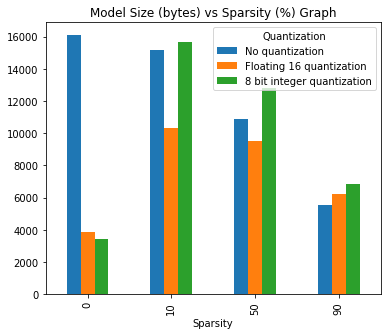

In [230]:
# INSERT YOUR PLOT CODE HERE

import matplotlib.pyplot as plt

# plot grouped bar chart
graph_df_Model_size = graphing_df_part_2[["Sparsity","Quantization","Model_Size"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Model_Size').reset_index().copy()
graph_df_Model_size = graph_df_Model_size[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_Model_size.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Model Size (bytes) vs Sparsity (%) Graph'
                      )

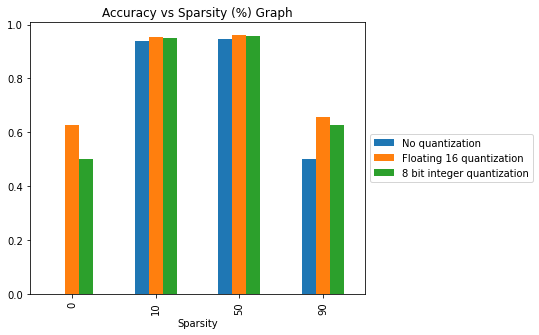

In [229]:
# INSERT YOUR PLOT CODE HERE

graph_df_Accuracy = graphing_df_part_2[["Sparsity","Quantization","Accuracy"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Accuracy').reset_index().copy()
graph_df_Accuracy = graph_df_Accuracy[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_Accuracy.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Accuracy vs Sparsity (%) Graph'
                      ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Quantization,Sparsity,8 bit integer quantization,Floating 16 quantization,No quantization
0,0,1.072884e-09,1.025200e-09,0.000138
1,10,2.527237e-09,2.598763e-09,0.000145
2,50,2.574921e-09,3.027916e-09,0.000147
3,90,2.622604e-09,4.315376e-09,0.000153


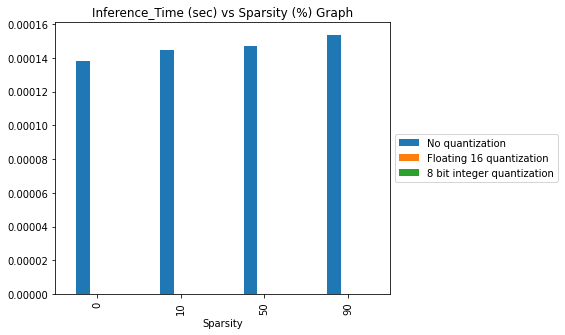

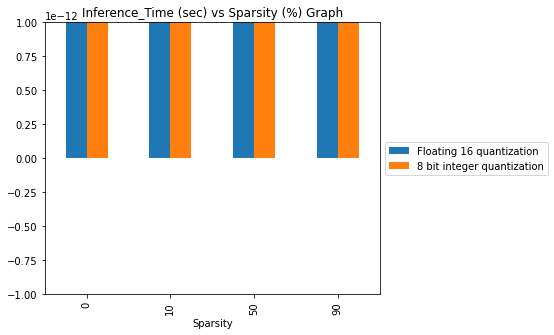

In [228]:
# INSERT YOUR PLOT CODE HERE

graph_df_inference_time = graphing_df_part_2[["Sparsity","Quantization","Inference_Time"]].sort_values(by='Sparsity').pivot(index='Sparsity', columns='Quantization', values='Inference_Time').reset_index().copy()
display(graph_df_inference_time)

graph_df_inference_time = graph_df_inference_time[["Sparsity", "No quantization", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_inference_time.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Inference_Time (sec) vs Sparsity (%) Graph'
                      ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

graph_df_inference_time = graph_df_inference_time[["Sparsity", "Floating 16 quantization", "8 bit integer quantization"]]
graph_df_inference_time.plot( x='Sparsity',
                          #y = 'Model_Size',
                          kind='bar',
                          stacked=False,
                          legend = True,
                          # xticks = ['No quantization', 'Floating 16 quantization', '8 bit integer quantization'],
                          # xticks = 'Quantization',
                          title='Inference_Time (sec) vs Sparsity (%) Graph'
                      ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization.

Pruning involves removing some of the parameters from a trained model to reduce its size. There are several techniques for pruning, including iterative pruning, etc. Pruning can significantly reduce the size of a model while maintaining or even improving its accuracy. However, the trade-off is that more aggressive pruning may result in a larger reduction in accuracy. On the other hand, less aggressive pruning may result in a smaller reduction in accuracy, but the model may still be larger than desired.

Quantization involves reducing the precision of the weights and activations in a model. For example, instead of using 32-bit floating point numbers, a model can be quantized to use 16-bit floating point numbers or 8-bit integers. This can significantly reduce the memory and computation requirements of a model. However, the trade-off is that quantization can result in a reduction in accuracy, especially if the precision is too low.

Network quantization and weight sharing further compresses the pruned network by reducing the
number of bits required to represent each weight


The tradeoffs:
1. Generally, we can see that the with quantization we are able to get maintain the accuracy and siffer minimal loss compared to the base model. While reducing our model size effectively.

2. We can observe that with more pruning levels, (higher than 50 in this case) tends to take a big impact on the accuracy. It does reduce the model size, but at the cost of reduced accuracy.

3. While comparing the trade-offs, we can say that it quantization is more effective in reducing the size while maintaing the accuracy of the model as compared to pruning.

Plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. Does the histogram of pruned weights give any insights on the accuracy observed?

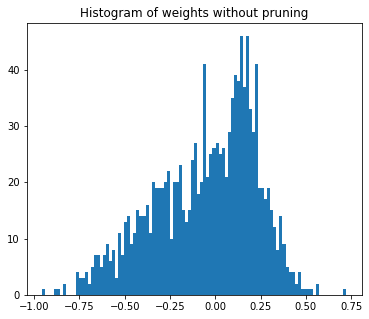

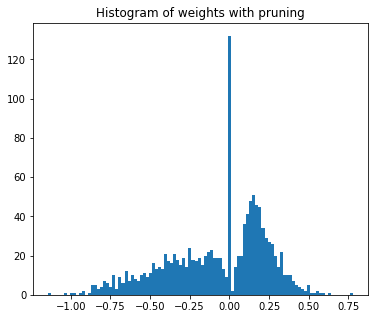

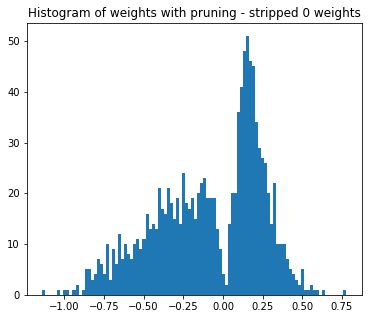

In [214]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
pruned_model = tf.keras.models.load_model('/content/stripped_pruned_model_part_1_q2.h5')

a = model.layers[3].weights
b = pruned_model.layers[3].weights
# print(b)

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()

plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()

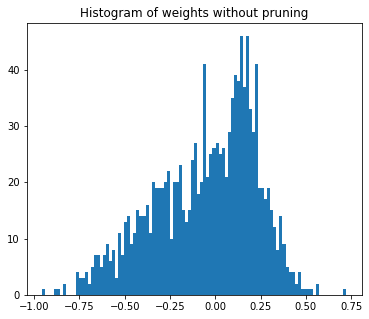

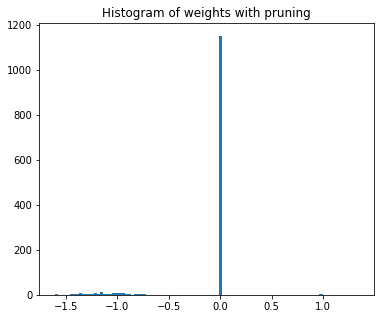

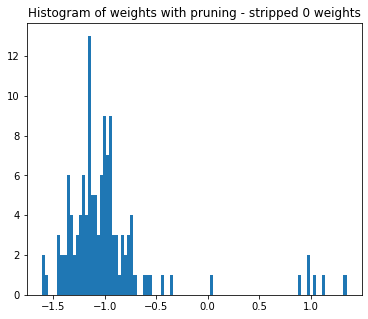

In [213]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
pruned_model = tf.keras.models.load_model('/content/stripped_pruned_model_part_1_q1.h5')

a = model.layers[3].weights
b = pruned_model.layers[3].weights
# print(b)

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()

plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()

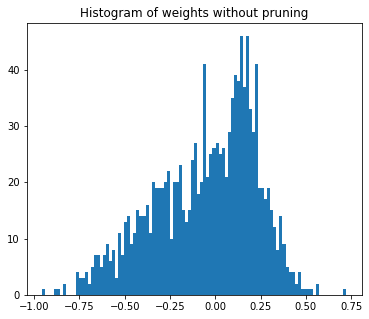

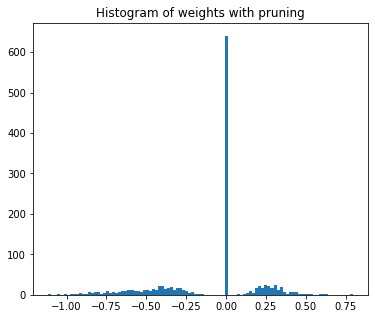

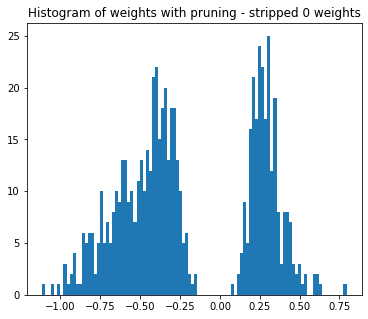

In [207]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
pruned_model = tf.keras.models.load_model('/content/stripped_pruned_model.h5')

a = model.layers[3].weights
b = pruned_model.layers[3].weights
# print(b)

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()

plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()

Does the histogram of pruned weights give any insights on the accuracy observed?

Yes, we can observe the histogram to gain insights on the accuracy. 

When pruning a model, the smallest magnitude weights are often removed (usually the 0 weights are removed based on the percentage mentioned), which can result in a sparsity pattern where some weights are removed entirely, and others remain intact. The histogram of pruned weights shows the distribution of the magnitude of the remaining weights in the pruned model. This can give insights into the importance of the remaining weights and how much they contribute to the accuracy of the model.

If the histogram of pruned weights shows a narrow distribution with many weights close to zero, it suggests that the model contains a large number of unimportant weights that can be removed without significantly affecting the model's accuracy. In this case, aggressive pruning can be applied without significant loss in accuracy.

Example in the first histogram we can see that the the histogram of weights shows that the wieghts are skewed towards the left. After prunining most of the 0 wieghts the wieghts distribution shifts towards the left.

In the second histogram, we can see that the histogram of weights shows that the wieghts are skewed towards the center. This suggests that the model contains a large number of unimportant weights. Once pruned, we can see that there is a large gap in the middle and there are 2 distrubution of wieghts in the pruned histogram of weights.

On the other hand, if the histogram of pruned weights shows a wide distribution with a significant number of weights that are not close to zero, it suggests that the model contains many important weights that cannot be pruned without significantly affecting the model's accuracy. In this case, more conservative pruning is necessary to maintain accuracy.

# Bonus: Visualize Pruning
In this section we will graph a small subset of the weights at different levels of pruning. The graphs clearly show how different sparsity levels affect the number of zero weights, it also shows that our pruning is unstructured.

We also provide histograms of the weights before and after pruning.

Note: Make sure you have saved the tflite files with the same names used below, alternatively you can change the model path with your correct file name. The first visualization relies on files collected from the exercise in PART 3!

In [90]:
def get_tensor_data(model_path):
  # Load tflite file with the created pruned model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()

  # Weights of the dense layer that has been pruned.
  tensor_name = 'sequential/dense_1/MatMul'
  detail = [x for x in details if tensor_name in x["name"]]

  # We need the first layer.
  tensor_data = interpreter.tensor(detail[0]["index"])()
  return tensor_data

# The value 10 is chosen for convenience.
width = height = 10


def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_weights_graph(tensor_data, sparsity):
  weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
  weights_to_display = weights_to_display[0:width, 0:height]

  val_ones = np.ones([height, width])
  val_zeros = np.zeros([height, width])
  subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

  plot_separation_lines(height, width)

  plt.axis('off')
  plt.imshow(subset_values_to_display)
  plt.colorbar()
  plt.title("Pruned weights for {0}% sparsity".format(sparsity))
  plt.show()

## USE YOUR MODEL PATH
plot_weights_graph(get_tensor_data('pruned_0.9_fp16_quantized_tflite_model.tflite'), 90)
plot_weights_graph(get_tensor_data('pruned_0.5_fp16_quantized_tflite_model.tflite'), 50)
plot_weights_graph(get_tensor_data('pruned_0.1_fp16_quantized_tflite_model.tflite'), 10)
plot_weights_graph(get_tensor_data('pruned_0_fp16_quantized_tflite_model.tflite'), 0)

ValueError: ignored

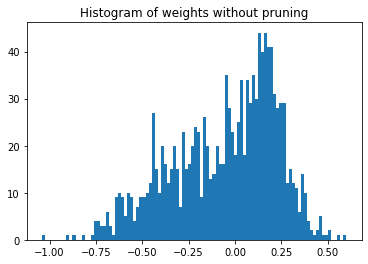

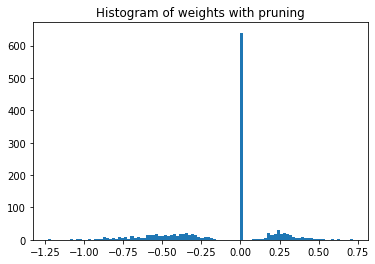

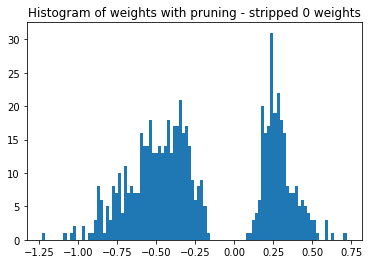

In [39]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()